In [10]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from joblib import Parallel, delayed

from ucimlrepo import fetch_ucirepo 
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

display_pca = False

# Overall function definitions

In [11]:
class InstanceSelectionProblem_2_Obj(Problem):
	n_neighbors = 5
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		out["F"] = np.column_stack([f1, f2])

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= InstanceSelectionProblem_2_Obj.n_neighbors:
			optimization_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1

class InstanceSelectionProblem_3_Obj(Problem):
	n_neighbors = 5
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=3,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		f3 = Parallel(n_jobs=-1)(delayed(self.calculate_instance_IR)(instance) for instance in x)
		
		out["F"] = np.column_stack([f1, f2, f3])

	def calculate_instance_IR(self, instance):
		num_1_class = np.sum(self.y_train[instance])
		num_0_class = self.n_instances - num_1_class
		IR = max(num_0_class, num_1_class) / min(num_0_class, num_1_class)
		return IR

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= InstanceSelectionProblem_3_Obj.n_neighbors:
			optimization_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_3_Obj.n_neighbors)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1
		
def split_and_scale_datasets(X, y, split_1=0.5, split_2=0.5, random_state=42, scale=True):
	X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=split_1, random_state=random_state, stratify=y)
	X_val, X_test, y_val, y_test =  train_test_split(X_temp, y_temp, test_size=split_2, random_state=random_state, stratify=y_temp)

	if scale:
		scaler = StandardScaler()
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)
		X_val = scaler.transform(X_val)

	return X_train, X_val, X_test, y_train, y_val, y_test

def set_summary(dataset, set_name, print_res=True):

	if "x" in set_name.lower():
		num_examples = dataset.shape[0]
		num_features = dataset.shape[1]
		
		if print_res:
			print(f"\nSummary for set {set_name}")
			print(f"\t- Num examples: {num_examples}")
			print(f"\t- Num features: {num_features}")

		else:
			return num_examples, num_features
		
	if "y" in set_name:
		counts = pd.DataFrame(dataset).value_counts()
		class_0_count = counts[0]
		class_1_count = counts[1]

		majority_class = max(class_0_count, class_1_count)
		minority_class = min(class_0_count, class_1_count)

		majority_class_name = 0 if majority_class == class_0_count else class_1_count

		if print_res:
			print(f"\nSummary for set {set_name}")
			print(f"\t- Number of examples in class 0: {class_0_count}")
			print(f"\t- Number of examples in class 1: {class_1_count}")
			print(f"\t- Total number of examples: {class_0_count + class_1_count}")
			print(f"\t- Imbalance ratio: {round(majority_class/minority_class, 4)} (Majority class is {majority_class_name})")		
		
		else:
			return class_0_count, class_1_count, round(majority_class/minority_class, 4)

def generate_PCA(X, y, plot_title):
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)
	plt.figure(figsize=(8, 6))
	plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k')
	plt.title(plot_title)
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	return X_pca, pca


# Defining and packaging datasets

In [12]:
datasets = []

# Load the dataset
df = pd.read_csv("KNNAlgorithmDataset.csv")
df = df.drop(columns='id')
df = df.drop(columns='Unnamed: 32')
X = df.drop(columns='diagnosis')
y = df['diagnosis']
# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

class_0_count, class_1_count, IR = set_summary(y_train, "y_train", False)
if class_0_count > class_1_count:
	minority_class_indicies = np.where(y_train == 1)
else:
	minority_class_indicies = np.where(y_train == 0)

X_train = np.concatenate((X_train, X_train[minority_class_indicies]), axis=0)
y_train = np.concatenate((y_train, y_train[minority_class_indicies]), axis=0)

datasets.append([X, y, X_train, X_val, X_test, y_train, y_val, y_test, "Cancer"])

# Load the dataset
df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')
X = df.drop(columns='Class')
y = df['Class']
# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

class_0_count, class_1_count, IR = set_summary(y_train, "y_train", False)
if class_0_count > class_1_count:
	minority_class_indicies = np.where(y_train == 1)
else:
	minority_class_indicies = np.where(y_train == 0)

X_train = np.concatenate((X_train, X_train[minority_class_indicies]), axis=0)
y_train = np.concatenate((y_train, y_train[minority_class_indicies]), axis=0)

datasets.append([X, y, X_train, X_val, X_test, y_train, y_val, y_test, "glass1"])


# Read dataset
df = pd.read_csv("Datasets/pima/pima.csv", delimiter=',')
X = df.drop(columns='Diabetic')
y = df['Diabetic']
# Generate train, validation, and test sets
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

class_0_count, class_1_count, IR = set_summary(y_train, "y_train", False)
if class_0_count > class_1_count:
	minority_class_indicies = np.where(y_train == 1)
else:
	minority_class_indicies = np.where(y_train == 0)

X_train = np.concatenate((X_train, X_train[minority_class_indicies]), axis=0)
y_train = np.concatenate((y_train, y_train[minority_class_indicies]), axis=0)

datasets.append([X, y, X_train, X_val, X_test, y_train, y_val, y_test, "pima"])


C:\Users\RjKim\AppData\Local\Temp\ipykernel_21056\1579492966.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("Datasets/glass1/glass1.csv", delimiter=', ')


Executing for Cancer


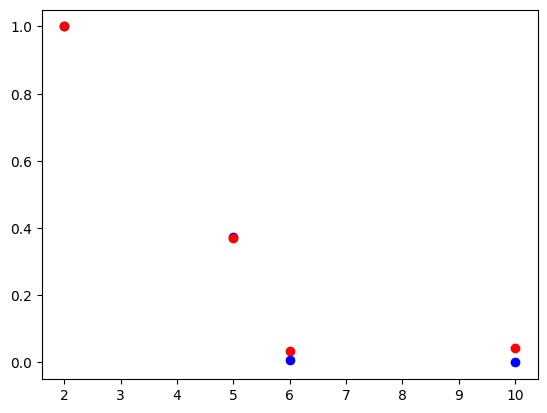

Executing for glass1


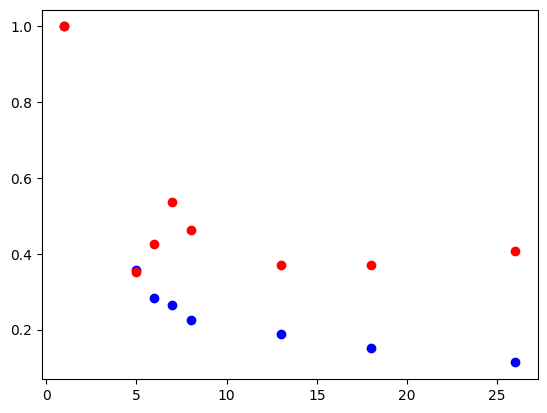

Executing for pima


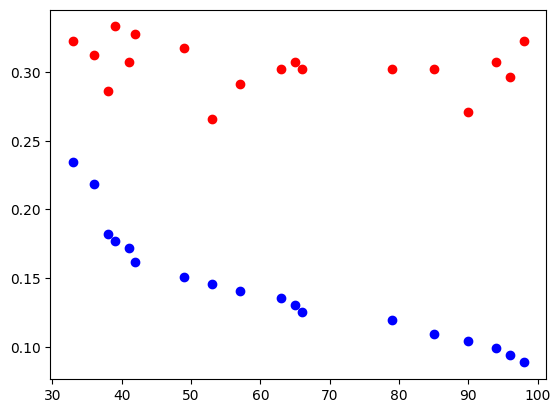

In [13]:
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, NAME in datasets:
	
	print(f"Executing for {NAME}")

	num_examples, num_features = set_summary(X, 'x', print_res=False)
	class_0_count, class_1_count, IR = set_summary(y, 'y', print_res=False)

	# Determine baseline accuracy of classifier on all examples
	baseline_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
	baseline_knn.fit(X_train, y_train)
	y_pred = baseline_knn.predict(X_test)
	baseline_test_acc = accuracy_score(y_test, y_pred)

	# Run GA optimization
	problem_1 = InstanceSelectionProblem_2_Obj(X_train, y_train, X_val, y_val)
	problem_2 = InstanceSelectionProblem_3_Obj(X_train, y_train, X_val, y_val)
	algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
	res1 = minimize(problem_1, algorithm, ('n_gen', 100), verbose=False, seed=42)
	res2 = minimize(problem_2, algorithm, ('n_gen', 100), verbose=False, seed=42)

	best_solution_1 = res1.X[0]
	x_train_filtered, y_train_filtered = X_train[best_solution_1], y_train[best_solution_1]
	_, _, bs1_IR = set_summary(y_train_filtered, 'y', print_res=False)
	num_instances_in_solution_1 = y_train_filtered.shape[0]
	final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
	final_test_knn.fit(x_train_filtered, y_train_filtered)
	y_pred = final_test_knn.predict(X_test)
	optimized_test_acc_1 = accuracy_score(y_test, y_pred)

	
	test_pareto_front = []
	fronts = NonDominatedSorting().do(res1.F, only_non_dominated_front=True)
	unique_F, unique_indices = np.unique(res1.F[fronts], axis=0, return_index=True)
	for idx, instance in enumerate(res1.X[unique_indices]):
		x_filtered, y_filtered = X_train[instance], y_train[instance]
		
		if x_filtered.shape[0] < InstanceSelectionProblem_2_Obj.n_neighbors:
			acc = 1
		
		else:
			knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(X_test)
			acc = 1 - accuracy_score(y_test, y_pred)
		test_pareto_front.append([x_filtered.shape[0], acc])

	x1 = [row[0] for row in unique_F]
	y1 = [row[1] for row in unique_F]

	x2 = [row[0] for row in test_pareto_front]
	y2 = [row[1] for row in test_pareto_front]

	plt.scatter(x1, y1, c='b')
	plt.scatter(x2, y2, c='r')
	plt.show()

	best_solution_2 = res2.X[0]
	x_train_filtered, y_train_filtered = X_train[best_solution_2], y_train[best_solution_2]
	_, _, bs2_IR = set_summary(y_train_filtered, 'y', print_res=False)
	num_instances_in_solution_2 = y_train_filtered.shape[0]
	final_test_knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
	final_test_knn.fit(x_train_filtered, y_train_filtered)
	y_pred = final_test_knn.predict(X_test)
	optimized_test_acc_2 = accuracy_score(y_test, y_pred)

	# test_pareto_front = []
	# fronts = NonDominatedSorting().do(res2.F, only_non_dominated_front=True)
	# unique_F, unique_indices = np.unique(res2.F[fronts], axis=0, return_index=True)
	# for idx, instance in enumerate(res2.X[unique_indices]):
	# 	x_filtered, y_filtered = X_train[instance], y_train[instance]
		
	# 	if x_filtered.shape[0] < InstanceSelectionProblem_2_Obj.n_neighbors:
	# 		acc = 1
		
	# 	else:
	# 		knn = KNeighborsClassifier(n_neighbors=InstanceSelectionProblem_2_Obj.n_neighbors)
	# 		knn.fit(x_filtered, y_filtered)
	# 		y_pred = knn.predict(X_test)
	# 		acc = 1 - accuracy_score(y_test, y_pred)
	# 		_, _, temp_IR = set_summary(y_filtered, 'y', False)
	# 	test_pareto_front.append([x_filtered.shape[0], acc, temp_IR])

	# 	x1 = [row[0] for row in unique_F]
	# 	y1 = [row[1] for row in unique_F]
	# 	z1 = [row[2] for row in unique_F]
	# 	x2 = [row[0] for row in test_pareto_front]
	# 	y2 = [row[1] for row in test_pareto_front]
	# 	z2 = [row[2] for row in test_pareto_front]

	# 	fig = plt.figure()
	# 	ax = fig.add_subplot(projection='3d')
	# 	ax.scatter(x1, y1, z1, c='b')
	# 	ax.scatter(x2, y2, z2, c='r')
	# 	plt.show()

	results.append([NAME, 
					num_features, 
					num_examples,
					X_train.shape[0],
					num_instances_in_solution_1,
					num_instances_in_solution_2,
				 	round(baseline_test_acc*100,2), 
					round(optimized_test_acc_1*100,2), 
					round(optimized_test_acc_2*100,2), 
					IR,
					bs1_IR,
					bs2_IR])

	# Plot PCA of the test set highlighting the selected instance examples
	if display_pca:
		selected_indices_idx = []
		for row in x_train_filtered:
			selected_indices_idx.append(np.where((row == X_train).all(axis=1))[0][0])
		x_train_selections = X_train[selected_indices_idx]

		X_pca, pca = generate_PCA(X_test, y_test, 'PCA of KNN Dataset (Blue-Benign & Red-Malignant)')
		X_train_pca = pca.transform(x_train_filtered)
		plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train_filtered, cmap='PRGn', linewidth=1, edgecolors='y')
		plt.show()

In [14]:
report_columns = "Dataset",  "# Feature", "# Example", "# Training Examples","Optimized # Examples (2 Obj)", "Optimized # Examples (3 Obj)", "Baseline Acc %", "Optimized Acc % (2 Obj)", "Optimized Acc % (3 Obj)", "IR of entire dataset", "Best solution IR (2 Obj)", "Best solution IR (3 Obj)"
pd.DataFrame(results, columns=report_columns)

,Dataset,# Feature,# Example,# Training Examples,Optimized # Examples (2 Obj),Optimized # Examples (3 Obj),Baseline Acc %,Optimized Acc % (2 Obj),Optimized Acc % (3 Obj),IR of entire dataset,Best solution IR (2 Obj),Best solution IR (3 Obj)
0,Cancer,30,569,390,5,112,97.20,62.94,37.76,1.6840,1.5000,36.3333
1,glass1,9,214,145,26,89,70.37,59.26,61.11,1.8158,1.1667,3.9444
2,pima,8,768,518,57,277,69.79,70.83,62.50,1.8657,1.1923,2.6933
